In [1]:
!pip install sentencepiece
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import sentencepiece as spm
import torch
import torch.nn as nn
import torchvision
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm 
import json
import pandas as pd

# 0. 서론

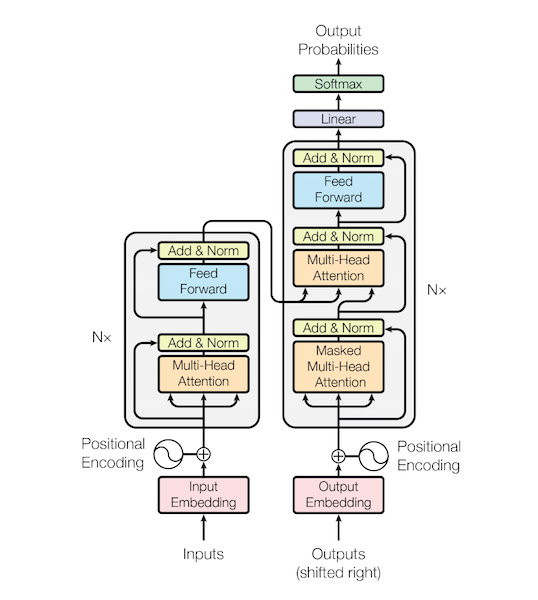

Transformer는 자연어처리에서 가장 중요한 논문이라고 생각이 됩니다. 이유는 2019년 12월 현재 각종 Benchmark 에서 가장 좋은 성능을 내고 있는 모델들이 Transformer 기반의 Pretrained 모델이기 때문 입니다.

이 포스트는 Transformer 모델 구현에 대한 내용 입니다. 논문에 대한 내용은 [Attention Is All You Need](https://arxiv.org/abs/1706.03762) 논문을 참고 하거나 다른 블로그를 참고 하세요.

# (1/3)

## 1. Vocab

Sentencepiece를 활용해 Vocab 만들기를 통해 만들어 놓은 vocab을 이용해 텍스트를 입력 tensor로 변경 합니다.

In [3]:
# vocab loading
vocab_file = "drive/MyDrive/Colab Notebooks/3.5. 영화 리뷰 감성 분석/Vocab/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# 입력 texts
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

# text를 tensor로 변환
inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  inputs.append(torch.tensor(ids))
  print(pieces)

# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
# shape
print(inputs.size())
# 값
print(inputs)

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']
torch.Size([2, 8])
tensor([[3195, 3632,  199, 3984, 3787, 3618,    0,    0],
        [ 193, 3634,   53, 3863, 3624, 3710, 3787, 3618]])


## 2. Embedding

Transformer의 Embedding은 ‘Input Embedding’과 ‘Postion Embedding’ 두 가지를 합해서 사용 합니다.

- Input Embedding

embedding은 입력 토큰을 vector 형태로 변환 합니다.

1. inputs에 대한 embedding 값 input_embs를 구합니다.

In [4]:
n_vocab = len(vocab) # vocab count
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding 객체

input_embs = nn_emb(inputs) # input embedding
print(input_embs.size())

torch.Size([2, 8, 128])


위와 같이 inputs(2, 8)에 대한 embedding값 input_embs(2, 8, 128) shape을 갖습니다.

- Position Embedding

Position encoding값을 구하기 위한 함수는 아래와 같습니다.

* 각 position별도 angle 값을 구합니다.
* 구해진 angle 중 짝수 index의 값에 대한 sin 값을 구합니다.
* 구해진 angle 중 홀수 index의 값에 대한 cos 값을 구합니다.

In [5]:
# sinusoid position embedding
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

아래와 같이 position encoding값을 구하면 됩니다.

(64, 128)


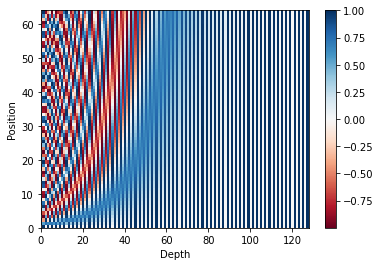

In [6]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print (pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

위에서 구한 결과를 그래프로 출력하면 아래와 같이 각 position 별로 다른 값을 갖는 것을 확인 할 수 있습니다.



아래 절차로 position embedding 값을 구합니다.

1. 학습되는 값이 아니므로 freeze옵션을 True로 설정 합니다.
2. 입력 inputs과 동일한 크기를 갖는 positions값을 구합니다.
3. input값 중 pad(0)값을 찾습니다.
4. positions값중 pad부분은 0으로 변경 합니다.
5. positions값에 해당하는 embedding값을 구합니다.

In [7]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print(inputs)
print(positions)
print(pos_embs.size())

tensor([[3195, 3632,  199, 3984, 3787, 3618,    0,    0],
        [ 193, 3634,   53, 3863, 3624, 3710, 3787, 3618]])
tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
torch.Size([2, 8, 128])


위의 출력한 결과는 아래와 같습니다. inputs의 pad(0) 위치에 positions의 값도 pad(0)으로 변경 되어 있음을 알 수 있습니다.

pos_embs(3, 13, 128)은 input_embs(3, 13, 128)과 shape이 동일합니다

위에서 구한 input_embs과 pos_embs를 더하면 transformer에 입력할 input이 됩니다.

In [8]:
input_sums = input_embs + pos_embs

## 3. Scaled Dot Product Attention

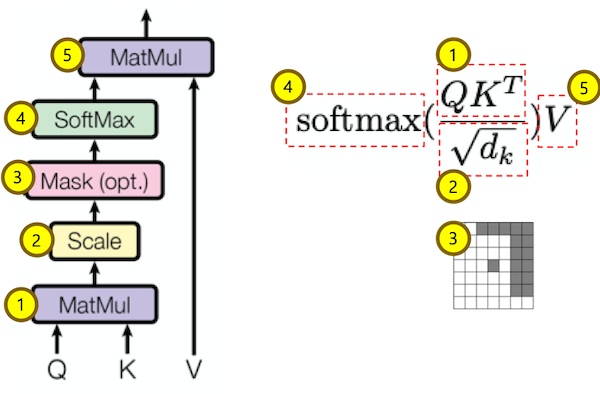

**입력값**

입력값은 Q(query), K(key), V(value) 그리고 attention mask로 구성 되어 있습니다.

입력값 중 K, V는 같은 값 이어야 합니다.

Q, K, V가 모두 동일한 경우는 self attention이라 합니다.

In [9]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

torch.Size([2, 8, 8])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])


attn_mask의 값은 pad(0) 부분만 True 입니다.

**MatMul Q, K-transpose**

위 그림의 수식 중 1번 Q * K-transpose를 하는 코드 입니다.

In [10]:
scores = torch.matmul(Q, K.transpose(-1, -2))
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[218.2254,  54.7249,  55.0861,  59.0294,  62.7689,  63.0549,  66.8200,
          66.8200],
        [ 54.7249, 222.6491,  66.9114,  46.2069,  63.2039,  59.6518,  43.9225,
          43.9225],
        [ 55.0861,  66.9114, 211.9703,  56.9441,  33.4953,  57.7186,  68.3326,
          68.3326],
        [ 59.0294,  46.2069,  56.9441, 159.0954,  42.0032,  65.8995,  49.2361,
          49.2361],
        [ 62.7689,  63.2039,  33.4953,  42.0032, 156.9303,  64.1452,  61.6076,
          61.6076],
        [ 63.0549,  59.6518,  57.7186,  65.8995,  64.1452, 221.3589,  44.2060,
          44.2060],
        [ 66.8200,  43.9225,  68.3326,  49.2361,  61.6076,  44.2060, 178.7391,
         178.7391],
        [ 66.8200,  43.9225,  68.3326,  49.2361,  61.6076,  44.2060, 178.7391,
         178.7391]], grad_fn=<SelectBackward0>)


각 단어상호간에 가중치를 표현하는 테이블이 생성 되었습니다.

**Scale**

위 그림의 수식 중 2번 k-dimension에 루트를 취한 값으로 나누는 코드 입니다.

In [11]:
d_head = 64
scores = scores.mul_(1/d_head**0.5)
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[27.2782,  6.8406,  6.8858,  7.3787,  7.8461,  7.8819,  8.3525,  8.3525],
        [ 6.8406, 27.8311,  8.3639,  5.7759,  7.9005,  7.4565,  5.4903,  5.4903],
        [ 6.8858,  8.3639, 26.4963,  7.1180,  4.1869,  7.2148,  8.5416,  8.5416],
        [ 7.3787,  5.7759,  7.1180, 19.8869,  5.2504,  8.2374,  6.1545,  6.1545],
        [ 7.8461,  7.9005,  4.1869,  5.2504, 19.6163,  8.0181,  7.7009,  7.7009],
        [ 7.8819,  7.4565,  7.2148,  8.2374,  8.0181, 27.6699,  5.5257,  5.5257],
        [ 8.3525,  5.4903,  8.5416,  6.1545,  7.7009,  5.5257, 22.3424, 22.3424],
        [ 8.3525,  5.4903,  8.5416,  6.1545,  7.7009,  5.5257, 22.3424, 22.3424]],
       grad_fn=<SelectBackward0>)


위 값에 비해서 가중치 편차가 줄어든 것을 확인 할 수 있습니다.

**Mask (Opt.)**

위 그림 수식 중 3번 mask를 하는 코드 입니다.

In [12]:
scores.masked_fill_(attn_mask, -1e9)
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[ 2.7278e+01,  6.8406e+00,  6.8858e+00,  7.3787e+00,  7.8461e+00,
          7.8819e+00, -1.0000e+09, -1.0000e+09],
        [ 6.8406e+00,  2.7831e+01,  8.3639e+00,  5.7759e+00,  7.9005e+00,
          7.4565e+00, -1.0000e+09, -1.0000e+09],
        [ 6.8858e+00,  8.3639e+00,  2.6496e+01,  7.1180e+00,  4.1869e+00,
          7.2148e+00, -1.0000e+09, -1.0000e+09],
        [ 7.3787e+00,  5.7759e+00,  7.1180e+00,  1.9887e+01,  5.2504e+00,
          8.2374e+00, -1.0000e+09, -1.0000e+09],
        [ 7.8461e+00,  7.9005e+00,  4.1869e+00,  5.2504e+00,  1.9616e+01,
          8.0181e+00, -1.0000e+09, -1.0000e+09],
        [ 7.8819e+00,  7.4565e+00,  7.2148e+00,  8.2374e+00,  8.0181e+00,
          2.7670e+01, -1.0000e+09, -1.0000e+09],
        [ 8.3525e+00,  5.4903e+00,  8.5416e+00,  6.1545e+00,  7.7009e+00,
          5.5257e+00, -1.0000e+09, -1.0000e+09],
        [ 8.3525e+00,  5.4903e+00,  8.5416e+00,  6.1545e+00,  7.7009e+00,
          5.5257e+00, -1.0000e+09, -1.0000e

mask를 한 부분이 -1e9로 매우 작은 값으로 변경된 것을 확인 할 수 있습니다.

**Softmax**

위 그림 수식 중 4번 softmax를 하는 코드 입니다.

In [13]:
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])

torch.Size([2, 8, 8])
tensor([[1.0000e+00, 1.3307e-09, 1.3921e-09, 2.2790e-09, 3.6371e-09, 3.7695e-09,
         0.0000e+00, 0.0000e+00],
        [7.6548e-10, 1.0000e+00, 3.5115e-09, 2.6395e-10, 2.2092e-09, 1.4171e-09,
         0.0000e+00, 0.0000e+00],
        [3.0427e-09, 1.3342e-08, 1.0000e+00, 3.8382e-09, 2.0472e-10, 4.2283e-09,
         0.0000e+00, 0.0000e+00],
        [3.6960e-06, 7.4411e-07, 2.8479e-06, 9.9998e-01, 4.3998e-07, 8.7233e-06,
         0.0000e+00, 0.0000e+00],
        [7.7315e-06, 8.1635e-06, 1.9911e-07, 5.7672e-07, 9.9997e-01, 9.1829e-06,
         0.0000e+00, 0.0000e+00],
        [2.5479e-09, 1.6651e-09, 1.3076e-09, 3.6358e-09, 2.9199e-09, 1.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.3821e-01, 1.9327e-02, 4.0860e-01, 3.7550e-02, 1.7629e-01, 2.0024e-02,
         0.0000e+00, 0.0000e+00],
        [3.3821e-01, 1.9327e-02, 4.0860e-01, 3.7550e-02, 1.7629e-01, 2.0024e-02,
         0.0000e+00, 0.0000e+00]], grad_fn=<SelectBackward0>)


가중치가 확률로 변환 된 값을 볼 수 있습니다. mask를 한 부분이 모두 0이 되었습니다.



**MatMul attn_prov, V**

위 그림 수식 중 5번 attn_prov * V를 하는 코드 입니다.

In [14]:
context = torch.matmul(attn_prob, V)
print(context.size())

torch.Size([2, 8, 128])


Q와 동일한 shape 값이 구해집니다. 이 값은 V값들이 attn_prov의 가중치를 이용해서 더해진 값 입니다.

**Class**

위 절차를 하나의 클래스 행태로 구성하면 아래와 같습니다.

In [15]:
# scale dot product attention
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)                                   # 2번
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)     # 1번
        scores.masked_fill_(attn_mask, -1e9)                               # 3번
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)                             # 4번
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)                               # 5번
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

## 4. Multi-Head Attention

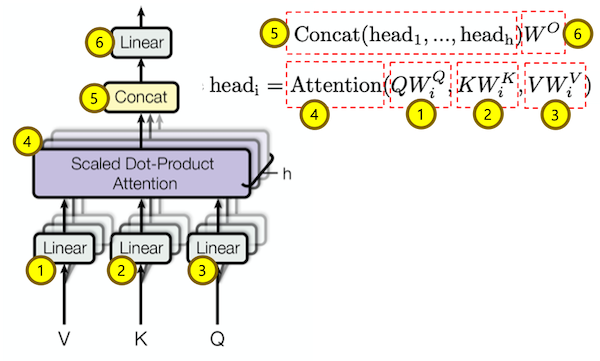

**입력값**

Q, K, V, attn_mask는 ScaledDotProductAttention과 동일 합니다.
head 개수는 2개 head의 dimension은 64 입니다.

In [16]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2

**Multi Head Q, K, V**

위 그림 수식 중 1번 Q를 여러개의 head로 나누는 과정 입니다.

In [17]:
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

# (bs, n_seq, n_head * d_head)
q_s = W_Q(Q)
print(q_s.size())
# (bs, n_seq, n_head, d_head)
q_s = q_s.view(batch_size, -1, n_head, d_head)
print(q_s.size())
# (bs, n_head, n_seq, d_head)
q_s = q_s.transpose(1,2)
print(q_s.size())

torch.Size([2, 8, 128])
torch.Size([2, 8, 2, 64])
torch.Size([2, 2, 8, 64])


Q값이 head단위로 나눠졌습니다.

위 과정을 한 줄로 표현하면 다음과 같습니다.

In [18]:
# (bs, n_head, n_seq, d_head)
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64])


Q, K, V 모두 Multi Head로 나눠졌습니다.

Attention Mask도 Multi Head로 변경 합니다.

In [19]:
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 8, 8])
torch.Size([2, 2, 8, 8])


Attention Mask도 Multi Head로 변경 되었습니다.

**Attention**

위 그림 수식 중 4번 Attention 과정 입니다.
이전에 설명한 ‘Scaled Dot Product Attention’을 사용합니다.

In [20]:
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 8, 64])
torch.Size([2, 2, 8, 8])


Multi Head에 대한 Attention이 구해 졌습니다.

**Concat**

위 그림 수식 중 5번 Concat 과정 입니다.

In [21]:
# (bs, n_seq, n_head * d_head)
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head)
print(context.size())

torch.Size([2, 8, 128])


Multi Head를 한개로 합쳤습니다.

**Linear**

위 그림 수식 중 6번 Linear 과정 입니다.

In [22]:
linear = nn.Linear(n_head * d_head, d_hidn)
# (bs, n_seq, d_hidn)
output = linear(context)
print(output.size())

torch.Size([2, 8, 128])


입력 Q와 동일한 shape을 가진 Multi Head Attention이 구해 졌습니다.

**Class**

위 절차를 하나의 클래스 행태로 구성하면 아래와 같습니다.

In [23]:
# multi head attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

## 5. Masked Multi-Head Attention

Masked Multi-Head Attention은 Multi-Head Attention과 attention mask를 제외한 부분은 모두 동일합니다.

**입력값**

In [24]:
# attention decoder mask
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


Q = input_sums
K = input_sums
V = input_sums

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask[1])
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[1])
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[1])

batch_size = Q.size(0)
n_head = 2

tensor([[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True],


pad mask, decoder mask 그리고 이 둘을 합한 attention mask를 확인 할 수 있습니다.

**Multi-Head Attention**

Multi-Head Attention과 동일하므로 위에서 선언한 MultiHeadAttention 클래스를 바로 호출 합니다.

In [25]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 8, 128]) torch.Size([2, 2, 8, 8])


## 6. FeeedForward

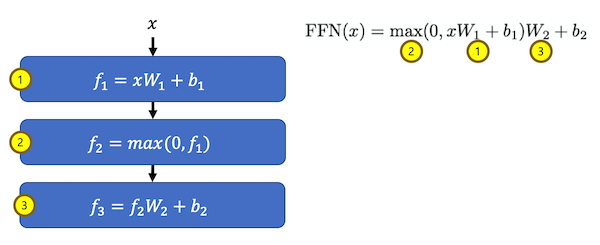

**f1 (Linear)**

위 그림 수식 중 1번 f1 (Linear) 과정 입니다.

In [26]:
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
# (bs, d_hidn * 4, n_seq)
ff_1 = conv1(output.transpose(1, 2))
print(ff_1.size())

torch.Size([2, 512, 8])


입력에 비해 hidden dimension이 4배 커진 것을 확인 할 수 있습니다.

**Activation (relu or gelu)**

위 그림 수식 중 2번 Activation (relu or gelu) 과정 입니다.
논문이 발표 될 당시는 relu를 사용하도록 되어 있었지만 이후 gelu를 사용할 때 더 성능이 좋다는 것이 발견되었습니다.

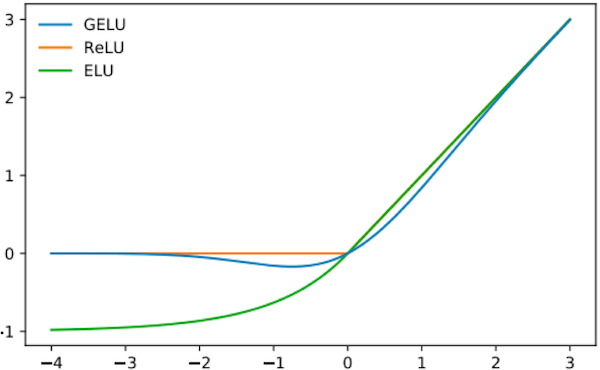

In [27]:
# active = F.relu
active = F.gelu
ff_2 = active(ff_1)

**f3 (Linear)**

위 그림 수식 중 3번 f3 (Linear) 과정 입니다.

In [28]:
conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1, 2)
print(ff_3.size())

torch.Size([2, 8, 128])


입력과 동일한 shape으로 변경된 결과를 확인 할 수 있습니다.

**Class**

위 절차를 하나의 클래스 행태로 구성하면 아래와 같습니다.

In [29]:
# feed forward
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output

# (2/3)

## 1. Config

(1/3)의 코드처럼 Transformer 모델에는 많은 설정이 필요합니다. 이 설정을 json 형태로 저장을 하고 이를 읽어서 처리하는 간단한 클래스 입니다.

In [30]:
# configuration json을 읽어들이는 class 
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

작은 리소스에서도 동작 가능하도록 여러 파라미터를 작게 설정 했습니다. 가지고 계신 GPU가 여유가 있다면 파라미터를 키우면 더 좋은 결과를 확인 할 수 있을 겁니다. 기본 파라미터는 config.json을 참고 하세요.

In [31]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_dec_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


위와 같은 파라미터 정보를 확인 할 수 있습니다.

## 2. Common Class


(1/3)에서 설명한 ‘Position Embedding’, ‘Multi-Head Attention’, ‘Feeed Forward’등의 코드 입니다.

**Position Encoding**

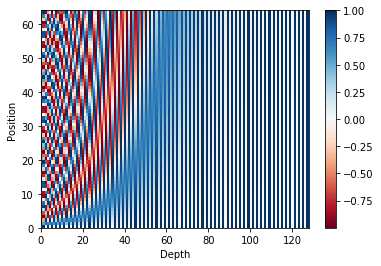

Position Embedding의 초기 값을 구하는 함수 입니다.

1. 각 position별 hidden index별 angle값을 구합니다. (줄: 8)
2. hidden 짝수 index의 angel값의 sin값을 합니다. (줄: 9)
3. hidden 홀수 index의 angel값의 cos값을 합니다. (줄: 10)

In [32]:
# sinusoid position encoding
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

**Attention Pad Mask**

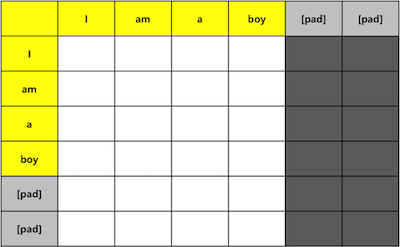

Attention을 구할 때 Padding 부분을 제외하기 위한 Mask를 구하는 함수 입니다.

1. K의 값 중에 Pad인 부분을 True로 변경 합니다. (나머지는 False) (줄: 5)
2. 구해진 값의 크기를 Q-len, K-len 되도록 변경 합니다. (줄: 6)

In [33]:
# attention pad mask
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad)
    pad_attn_mask= pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k)
    return pad_attn_mask

**Attention Decoder Mask**

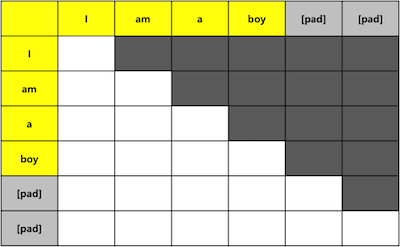

Decoder의 ‘Masked Multi Head Attention’에서 사용할 Mask를 구하는 함수 입니다. 현재단어와 이전단어는 볼 수 있고 다음단어는 볼 수 없도록 Masking 합니다.

1. 모든 값이 1인 Q-len, K-len 테이블을 생성 합니다. (줄: 3)
2. 대각선을 기준으로 아래쪽을 0으로 만듭니다. (줄: 4)

In [34]:
# attention decoder mask
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask

### **Scaled Dot Product Attention**

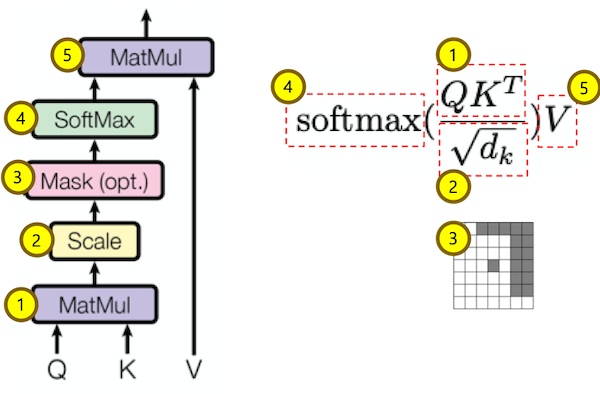

Scaled Dot Product Attention을 구하는 클래스 입니다.

1. Q * K.transpose를 구합니다. 
2. K-dimension에 루트를 취한 값으로 나줘 줍니다.
3. Mask를 적용 합니다.
4. Softmax를 취해 각 단어의 가중치 확률분포 attn_prob를 구합니다.
5. attn_prob * V를 구합니다. 구한 값은 Q에 대한 V의 가중치 합 벡터입니다.

In [35]:
# scale dot product attention
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2))
        scores = scores.mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

### Multi-Head Attention

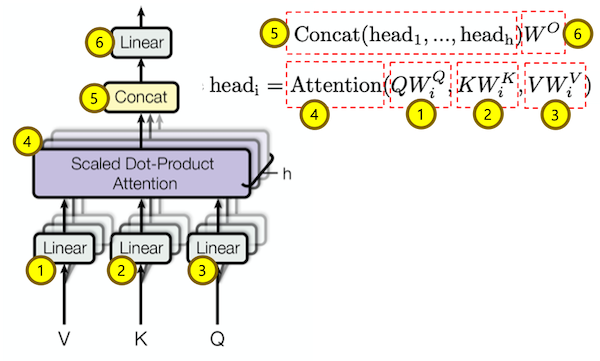

Multi-Head Attention을 구하는 클래스 입니다.

1. Q * W_Q를 한 후 multi-head로 나눕니다.
2. K * W_K를 한 후 multi-head로 나눕니다.
3. V * W_V를 한 후 multi-head로 나눕니다.
4. ScaledDotProductAttention 클래스를 이용해 각 head별 Attention을 구합니다. 
5. 여러 개의 head를 1개로 합칩니다.
6. Linear를 취해 최종 Multi-Head Attention값을 구합니다.

In [36]:
# multi head attention
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

### FeeedForward

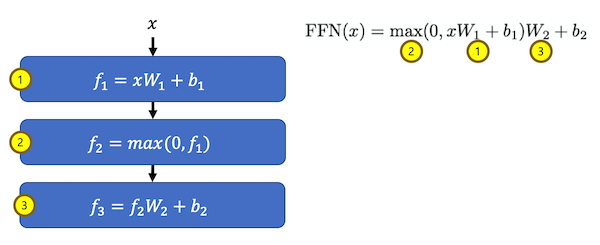

FeeedForward를 처리하는 클래스 입니다.

1. Linear를 실행하여 shape을 d_ff(hidden * 4) 크기로 키웁니다. 
2. activation 함수(relu or gelu)를 실행합니다. 
3. Linear를 실행하여 shape을 hidden 크기로 줄입니다. 

In [37]:
# feed forward
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.conv1(inputs.transpose(1, 2))
        output = self.active(output)
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

## 3. Encoder

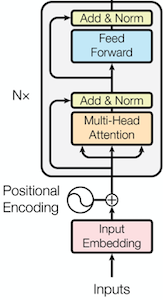

**Encoder Layer**

Encoder에서 루프를 돌며 처리 할 수 있도록 EncoderLayer를 정의하고 여러 개 만들어서 실행 합니다.

1. Multi-Head Attention을 수행합니다. (줄: 14) Q, K, V 모두 동일한 값을 사용하는 self-attention 입니다.
3. 1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 15)
4. 2번의 결과를 입력으로 Feed Forward를 실행 합니다. (줄: 17)
5. 3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 18)

In [38]:
# encoder layer
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        att_outputs = self.layer_norm1(inputs + att_outputs)
        # (bs, n_enc_seq, d_hidn)
        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob

**Encoder**

Encoder 클래스 입니다.

1. 입력에 대한 Position 값을 구합니다. (줄: 14~16)
2. Input Embedding과 Position Embedding을 구한 후 더합니다. (줄: 19)
3. 입력에 대한 attention pad mask를 구합니다. (줄: 22)
4. for 루프를 돌며 각 layer를 실행합니다. (줄: 27) layer의 입력은 이전 layer의 출력 값 입니다.

In [39]:
# encoder
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, inputs):
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_enc_seq, d_hidn)
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)

        # (bs, n_enc_seq, n_enc_seq)
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs

## 4. Decoder

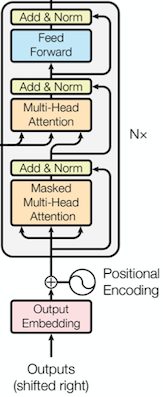

**Decoder Layer**

Decoder에서 루프를 돌며 처리 할 수 있도록 DecoderLayer를 정의하고 여러 개 만들어서 실행 합니다.

1. Multi-Head Attention을 수행합니다. (줄: 16)
Q, K, V 모두 동일한 값을 사용하는 self-attention 입니다.
2. 1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 17)
3. Encoder-Decoder Multi-Head Attention을 수행합니다. (줄: 19)
Q: 2번의 결과
K, V: Encoder 결과
4. 3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 20)
5. 4번의 결과를 입력으로 Feed Forward를 실행 합니다. (줄: 22)
6. 5번의 결과와 4번의 결과(residual)을 더한 후 LayerNorm을 실행 합니다. (줄: 23)

In [40]:
# decoder layer
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

**Decoder**

Decoder 클래스 입니다.

1. 입력에 대한 Position 값을 구합니다. (줄: 14~16)
2. Input Embedding과 Position Embedding을 구한 후 더합니다. (줄: 19)
3. 입력에 대한 attention pad mask를 구합니다. (줄: 22)
4. 입력에 대한 decoder attention mask를 구합니다. (줄: 24)
5. attention pad mask와 decoder attention mask 중 1곳이라도 mask되어 있는 부분인 mask 되도록 attention mask를 구합니다. (줄: 26)
6. Q(decoder input), K(encoder output)에 대한 attention mask를 구합니다. (줄: 28)
7. for 루프를 돌며 각 layer를 실행합니다. (줄: 27)
layer의 입력은 이전 layer의 출력 값 입니다.

In [41]:
# decoder
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
    
        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
        # (bs, n_dec_seq, n_enc_seq)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad)

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq), (bs, n_dec_seq, n_enc_seq)
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)], [(bs, n_dec_seq, n_enc_seq)]S
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

## 5. Transformer

Transformer 클래스 입니다.

1. Encoder Input을 입력으로 Encoder를 실행합니다. (줄: 12)
2. Encoder Output과 Decoder Input을 입력으로 Decoder를 실행합니다. (줄: 14)

In [42]:
# transformer
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

# (3/3)

## 1. Model

(2/3)의 Transformer 클래스를 이용하여 Naver 영화리뷰 감정분석 분류 모델 클래스를 아래와 같이 정의 합니다.

1. Encoder input과 Decoder input을 입력으로 Transformer 모델을 실행 합니다. (줄: 12)
2. Transformer 출력의 max값을 구합니다. (줄: 14)
3. Linear를 실행하여 최종 예측 결과를 만듭니다. (줄: 16)

In [43]:
# naver movie classfication
class MovieClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = Transformer(self.config)
        self.projection = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_dec_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs = self.transformer(enc_inputs, dec_inputs)
        # (bs, d_hidn)
        dec_outputs, _ = torch.max(dec_outputs, dim=1)
        # (bs, n_output)
        logits = self.projection(dec_outputs)
        # (bs, n_output), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return logits, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

## 2. DataSet

**DataSet**

Naver 영화리뷰 감정분석 데이터 셋 입니다.

1. 입력 파일로 부터 ‘label’을 읽어 들입니다. (줄: 16)
2. 입력 파일로 부터 ‘doc’ token을 읽어 숫자(token id)로 변경 합니다. (줄: 17)
3. Decoder 입력은 ‘[BOS]’로 고정 합니다. (줄: 26)

In [44]:
# 영화 분류 데이터셋
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                self.labels.append(data["label"])
                self.sentences.append([vocab.piece_to_id(p) for p in data["doc"]])
    
    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor([self.vocab.piece_to_id("[BOS]")]))

**collate_fn**

배치단위로 데이터 처리를 위한 collate_fn 입니다.

1. Encoder inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가 합니다. (줄: 5)
padding은 Sentencepiece를 활용해 Vocab 만들기에서 ‘–pad_id=0’옵션으로 지정한 값 입니다.
2. Decoder inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가 합니다. (줄: 6)
3. Label은 길이가 1 고정이므로 stack 함수를 이용해 tensor로 만듭니다. (줄: 9)

In [45]:
# movie data collate_fn
def movie_collate_fn(inputs):
    labels, enc_inputs, dec_inputs = list(zip(*inputs))

    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)

    batch = [
        torch.stack(labels, dim=0),
        enc_inputs,
        dec_inputs,
    ]
    return batch

**DataLoader**

위에서 정의한 DataSet과 collate_fn을 이용해 학습용(train_loader), 평가용(test_loader) DataLoader를 만듭니다.

In [46]:
batch_size = 128
train_dataset = MovieDataSet(vocab, "drive/MyDrive/Colab Notebooks/3.5. 영화 리뷰 감성 분석/Vocab/ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=movie_collate_fn)
test_dataset = MovieDataSet(vocab, "drive/MyDrive/Colab Notebooks/3.5. 영화 리뷰 감성 분석/Vocab/ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=movie_collate_fn)

Loading drive/MyDrive/Colab Notebooks/3.5. 영화 리뷰 감성 분석/Vocab/ratings_train.json: 100%|██████████| 149995/149995 [00:05<00:00, 29169.39 lines/s]
Loading drive/MyDrive/Colab Notebooks/3.5. 영화 리뷰 감성 분석/Vocab/ratings_test.json: 100%|██████████| 49997/49997 [00:01<00:00, 30138.67 lines/s]


## 3. Evaluate

학습된 MovieClassification 모델의 성능을 평가하기 위한 함수 입니다. 평가는 정확도(accuracy)를 사용 했습니다.

1. Encoder input과 Decoder input을 입력으로 MovieClassification을 실행합니다. (줄: 12)
2. 1번의 결과 중 첫 번째 값이 예측 logits 입니다. (줄: 13)
3. logits의 최대값의 index를 구합니다. (줄: 14)
4. 3번에게 구한 값과 labels의 값이 같은지 비교 합니다. (줄: 16)

In [47]:
# 모델 epoch 평가
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]
            _, indices = logits.max(1)

            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

## 4. Train

MovieClassification 모델을 학습하기 위한 함수 입니다.

1. Encoder input과 Decoder input을 입력으로 MovieClassification을 실행합니다. (줄: 11)
2. 1번의 결과 중 첫 번째 값이 예측 logits 입니다. (줄: 12)
3. logits 값과 labels의 값을 이용해 Loss를 계산합니다. (줄: 14)
4. loss, optimizer를 이용해 학습합니다. (줄: 18, 19)

In [48]:
# 모델 epoch 학습
def train_epoch(config, epoch, model, criterion, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train {epoch}") as pbar:
        for i, value in enumerate(train_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]

            loss = criterion(logits, labels)
            loss_val = loss.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

학습을 위한 추가적인 내용을 선언 합니다.

1. GPU 사용 여부를 확인합니다. (줄: 1)
2. 출력 값 개수를 정의 합니다. (부정(0), 긍정(1) 2가지입니다.) (줄: 2)
3. learning_rate 및 학습 epoch를 선언 합니다. (줄: 5, 6)

In [49]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 2
print(config)

learning_rate = 5e-5
n_epoch = 10

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda'), 'n_output': 2}


위에서 선언된 내용을 이용해 학습을 실행하는 절차 입니다.

1. MovieClassification을 생성합니다. (줄: 1)
2. MovieClassification이 GPU 또는 CPU를 지원하도록 합니다. (줄: 2)
3. loss 함수를 선언 합니다. (줄: 4)
4. optimizer를 선언 합니다. (줄: 5)
5. 각 epoch 마다 학습을 합니다. (줄: 9)
6. 각 epoch 마다 평가를 합니다. (줄: 10)

In [50]:
model = MovieClassification(config)
model.to(config.device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses, scores = [], []
for epoch in range(n_epoch):
    loss = train_epoch(config, epoch, model, criterion, optimizer, train_loader)
    score = eval_epoch(config, model, test_loader)

    losses.append(loss)
    scores.append(score)

Valid: 100%|██████████| 391/391 [00:50<00:00,  7.72it/s, Acc: 0.834]


## 5. Result

학습결과 및 평가결과는 아래와 같습니다.
정확도(score)가 83.5% 정도 나왔습니다.

,loss,score
0,0.480545,0.800088
1,0.401577,0.803108
2,0.375675,0.821289
3,0.355997,0.827830
4,0.334566,0.830310
5,0.314177,0.830750
6,0.293842,0.834230
7,0.270777,0.831950
8,0.248219,0.834130
9,0.225745,0.834490


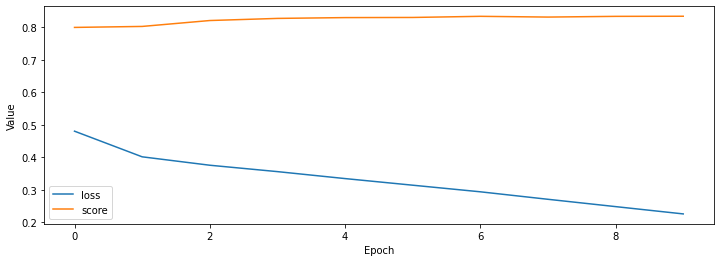

In [53]:
# table
data = {
    "loss": losses,
    "score": scores
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.plot(scores, label="score")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()